# Import Libraries

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=30,
                    validation_data=(X_val, y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])


  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)


You should consider upgrading via the 'C:\Users\ADMIN\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import hashlib
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow. keras.models import Sequential
from tensorflow .keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow. keras.applications import MobileNetV2
from tensorflow. keras.layers import GlobalAveragePooling2D
from tensorflow. keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow. keras import regularizers,  layers, models
from tensorflow. keras.regularizers import l2
from sklearn. metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn. metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Exploratory Data Analysis

## Data Reading and Inspection

In [ ]:
data_path = r'btltrinh'

train_df = pd.read_csv('Train.csv')
meta_df = pd.read_csv('Meta.csv')

train_df = train_df.merge(meta_df, on="ClassId", how="left")
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path_x,Path_y,ShapeId,ColorId,SignId
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,Meta/20.png,0,0,1.1
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,Meta/20.png,0,0,1.1
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,Meta/20.png,0,0,1.1
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,Meta/20.png,0,0,1.1
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,Meta/20.png,0,0,1.1


In [27]:
# Dataset's Shape and Columns
print("Number of samples:", len(train_df))
print("Number of unique classes:", train_df['ClassId'].nunique())
print("Columns:", train_df.columns.tolist())
train_df.info()

Number of samples: 39209
Number of unique classes: 43
Columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path_x', 'Path_y', 'ShapeId', 'ColorId', 'SignId']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path_x   39209 non-null  object
 8   Path_y   39209 non-null  object
 9   ShapeId  39209 non-null  int64 
 10  ColorId  39209 non-null  int64 
 11  SignId   38759 non-null  object
dtypes: int64(9), object(3)
memory usage: 3.6+ MB


In [28]:
# Check Missing Values 
print("\nMissing values per column:")
print(train_df.isnull().sum())


Missing values per column:
Width        0
Height       0
Roi.X1       0
Roi.Y1       0
Roi.X2       0
Roi.Y2       0
ClassId      0
Path_x       0
Path_y       0
ShapeId      0
ColorId      0
SignId     450
dtype: int64


## Class Distribution

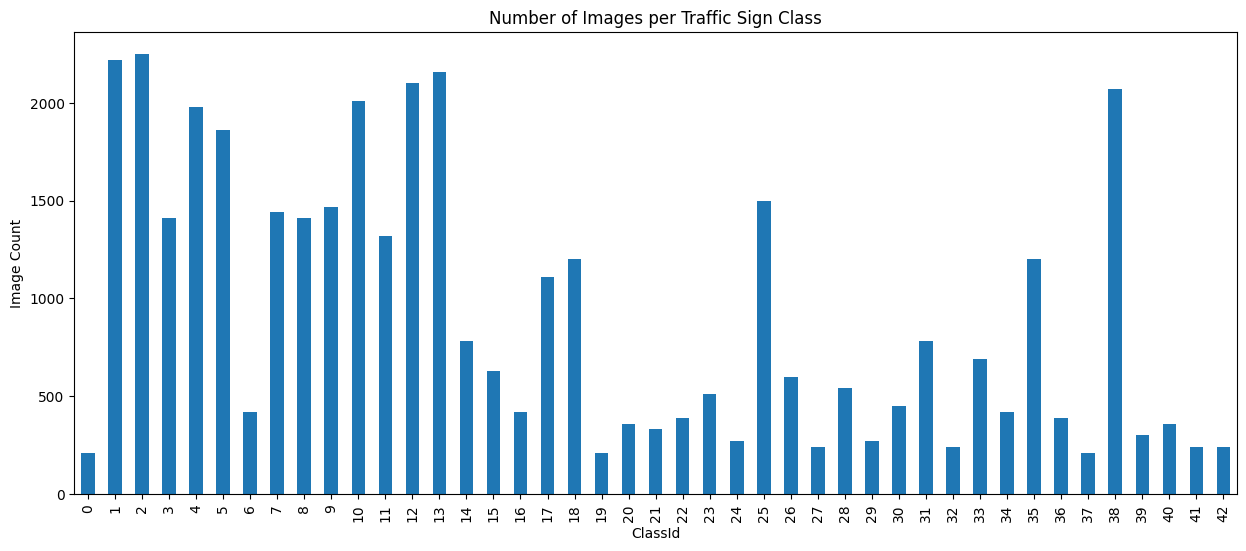

In [29]:
# Bar Chart for the distribution
plt.figure(figsize=(15,6))
train_df['ClassId'].value_counts().sort_index().plot(kind='bar')
plt.title("Number of Images per Traffic Sign Class")
plt.ylabel("Image Count")
plt.xticks(rotation=90)
plt.show()

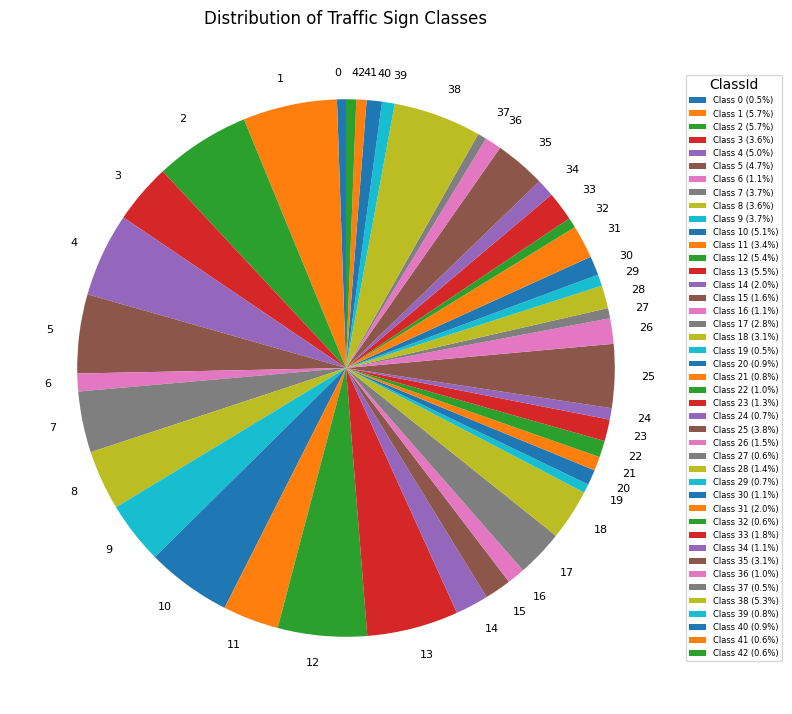

In [30]:
# Pie chart Distribution
class_counts = train_df['ClassId'].value_counts().sort_index()
total = class_counts.sum()

plt.figure(figsize=(8,8))
class_counts.plot(kind='pie', fontsize=8 ,startangle=90)
plt.title("Distribution of Traffic Sign Classes")
plt.ylabel("")

# Add the percentages of each label into the legend for better visualization
labels = [f"Class {cls} ({count/total*100:.1f}%)" for cls, count in class_counts.items()]
plt.legend( labels, title="ClassId",bbox_to_anchor=(1, 0.5), loc="center left", fontsize=6)
plt.tight_layout()
plt.show()

## Visualize and Understand the Images

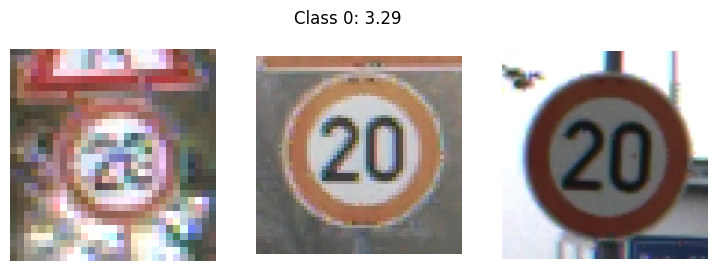

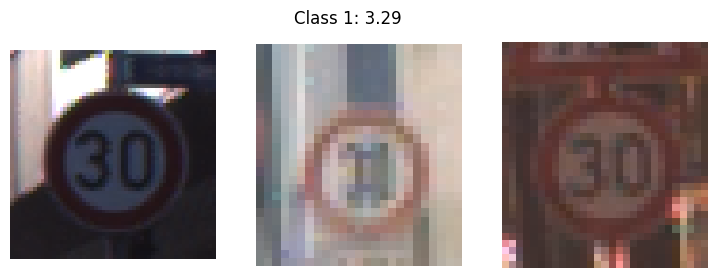

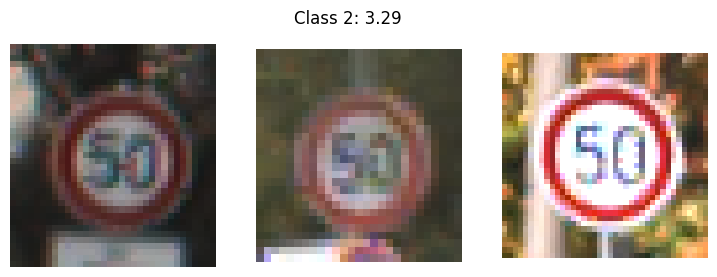

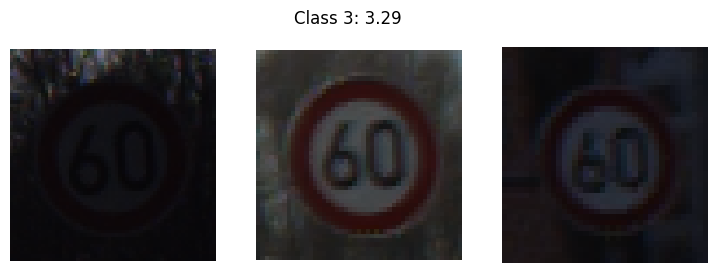

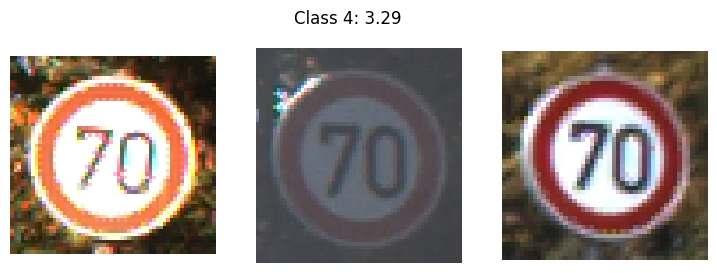

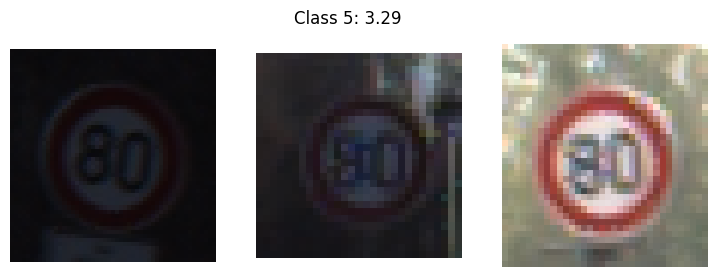

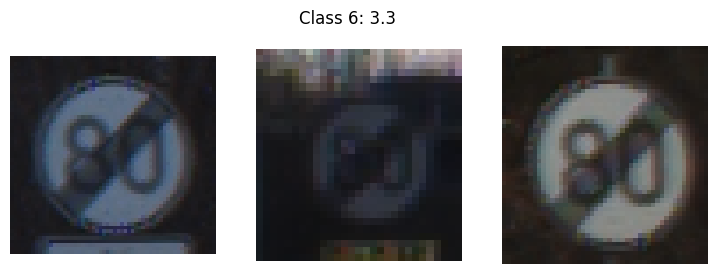

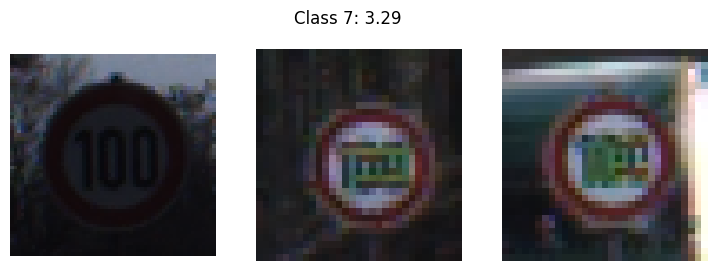

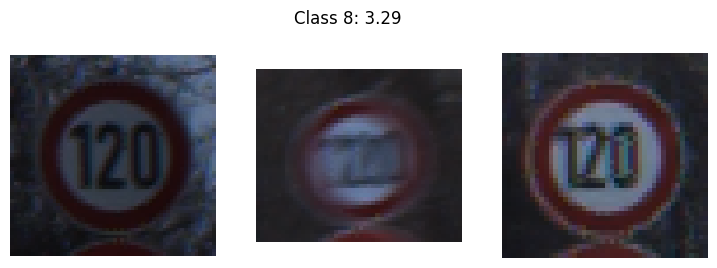

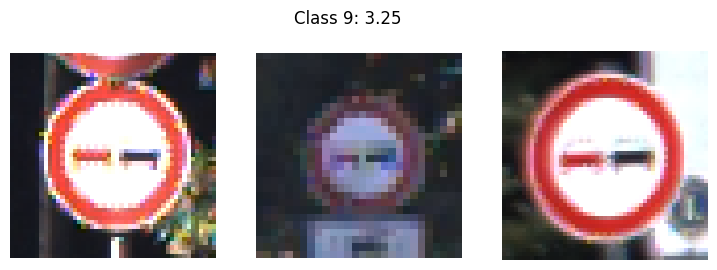

In [31]:
from PIL import Image

# Show 3 Samples for the first 10 classes 
classes = sorted(train_df['ClassId'].unique())
for class_id in classes[:10]:
    samples = train_df[train_df['ClassId'] == class_id].sample(3, random_state=42)
    fig, axes = plt.subplots(1, 3, figsize=(9,3))
    fig.suptitle(f"Class {class_id}: {samples['SignId'].iloc[0]}", fontsize=12)
    
    for idx, (i, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(data_path, row['Path_x'])
        img = Image.open(img_path) 
        axes[idx].imshow(img)
        axes[idx].axis("off")
    plt.show()

In [ ]:
# Image Size Statistics
sizes = []

for i in range(min(1000, len(train_df))):  
    img = cv2.imread(os.path.join(data_path, train_df['Path_x'].iloc[i]))
    h, w = img.shape[:2]   # height, width
    sizes.append((w, h))   # match PIL order: (Width, Height)

sizes_df = pd.DataFrame(sizes, columns=['Width', 'Height'])
display(sizes_df.describe())

,Width,Height
count,1000.000000,1000.000000
mean,50.714000,50.471000
std,20.757241,21.082163
min,25.000000,25.000000
25%,36.000000,35.000000
50%,45.000000,45.000000
75%,59.000000,59.000000
max,166.000000,170.000000


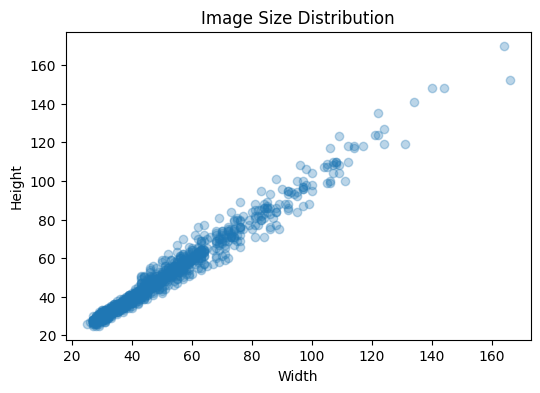

In [33]:
# Scatter plot of width vs height
plt.figure(figsize=(6,4))
plt.scatter(sizes_df['Width'], sizes_df['Height'], alpha=0.3)
plt.title("Image Size Distribution")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

In [34]:
# Check if any images are very small or very large
small_images = sizes_df[(sizes_df['Width'] < 20) | (sizes_df['Height'] < 20)]
large_images = sizes_df[(sizes_df['Width'] > 100) | (sizes_df['Height'] > 100)]
print(f"Small images: {len(small_images)}")
print(f"Large images: {len(large_images)}")

Small images: 0
Large images: 37


In [35]:
# Color Channel statistics 
R, G, B = [], [], []

for i in range(min(1000, len(train_df))):
    img = cv2.imread(os.path.join(data_path, train_df['Path_x'].iloc[i]))  # BGR order
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB
    arr = img.astype(np.float32) / 255.0  # normalize
    R.append(arr[:,:,0].mean())
    G.append(arr[:,:,1].mean())
    B.append(arr[:,:,2].mean())

print("Average normalized channel intensities (sample of 1000 images):")
print("Red  :", round(np.mean(R), 4))
print("Green:", round(np.mean(G), 4))
print("Blue :", round(np.mean(B), 4))

Average normalized channel intensities (sample of 1000 images):
Red  : 0.3836
Green: 0.3364
Blue : 0.331


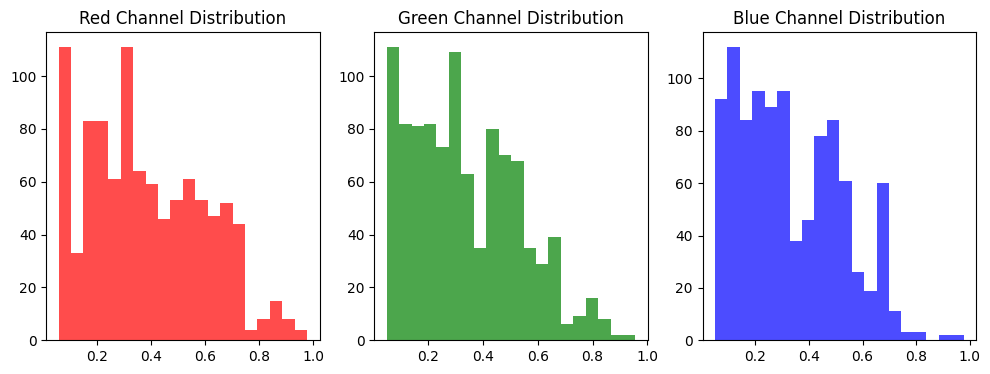

In [36]:
# Histogram of channel means
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(R, bins=20, color='r', alpha=0.7)
plt.title("Red Channel Distribution")
plt.subplot(1,3,2)
plt.hist(G, bins=20, color='g', alpha=0.7)
plt.title("Green Channel Distribution")
plt.subplot(1,3,3)
plt.hist(B, bins=20, color='b', alpha=0.7)
plt.title("Blue Channel Distribution")
plt.show()

In [37]:
# Calculate the Intra-class variance
class_variances = []

for class_id in sorted(train_df['ClassId'].unique()):
    samples = train_df[train_df['ClassId'] == class_id].sample(
        min(50, len(train_df[train_df['ClassId'] == class_id])), 
        random_state=42
    )
    
    all_pixels = []
    for path in samples['Path_x']:
        img = cv2.imread(os.path.join(data_path, path))  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)       
        arr = img.astype(np.float32) / 255.0             
        all_pixels.append(arr.reshape(-1, 3))  
    
    all_pixels = np.vstack(all_pixels)
    
    # calculate variance per channel
    r_var = all_pixels[:,0].var()
    g_var = all_pixels[:,1].var()
    b_var = all_pixels[:,2].var()
    overall_var = all_pixels.var()
    
    class_variances.append({
        "ClassId": class_id,
        "RedVariance": round(r_var, 6),
        "GreenVariance": round(g_var, 6),
        "BlueVariance": round(b_var, 6),
        "OverallVariance": round(overall_var, 6)
    })

variance_df = pd.DataFrame(class_variances)
display(variance_df)

,ClassId,RedVariance,GreenVariance,BlueVariance,OverallVariance
0,0,0.068295,0.084418,0.091083,0.082365
1,1,0.095074,0.096651,0.105678,0.099810
2,2,0.087972,0.082095,0.085595,0.086078
3,3,0.071021,0.079881,0.086177,0.079064
4,4,0.085109,0.079277,0.090423,0.085102
5,5,0.064407,0.065745,0.070996,0.067131
6,6,0.018454,0.020672,0.024184,0.021152
7,7,0.043233,0.037787,0.039393,0.040206
8,8,0.055028,0.044136,0.050103,0.049915
9,9,0.101131,0.091551,0.091449,0.096079


# Data PreProcessing

## Load Data & Prepare Data

In [38]:
data_path = r"D:\btltrinh"

df_train = pd.read_csv(r"D:\btltrinh\Train.csv")
df_test  = pd.read_csv(r"D:\btltrinh\Test.csv")


In [39]:
# Add full paths column to access the image easier
df_train['full_path'] = df_train['Path'].apply(lambda x: os.path.join(data_path, x))
df_test['full_path'] = df_test['Path'].apply(lambda x: os.path.join(data_path, x))

In [40]:
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,full_path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,D:\btltrinh\Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,D:\btltrinh\Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,D:\btltrinh\Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,D:\btltrinh\Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,D:\btltrinh\Train/20/00020_00000_00004.png


## Train - val split

In [41]:
# split
train_split, val_split = train_test_split(df_train,test_size=0.2,stratify=df_train['ClassId'],random_state=42)

In [42]:
# reset index 
train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)

## Image PreProcessing

In [43]:
# Resize Images to make all images a fixed size
IMG_SIZE = 64
BATCH_SIZE = 32

In [ ]:
def preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.ensure_shape(img, (None, None, 3))  
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])         
    img = tf.cast(img, tf.float32) / 255.0       
    return img, label  

In [45]:
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.15)  
    img = tf.image.random_contrast(img, 0.9, 1.1)  
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    img = tf.image.rot90(img, k)  
    return img, label

In [46]:
# Training Dataset 
train_ds = tf.data.Dataset.from_tensor_slices((train_split['full_path'].values, train_split['ClassId'].values))
train_ds = (train_ds .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).map(augment, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000)
    .batch(BATCH_SIZE) .prefetch(tf.data.AUTOTUNE))

In [47]:
# Validation Dataset 
val_ds = tf.data.Dataset.from_tensor_slices( (val_split['full_path'].values, val_split['ClassId'].values))
val_ds = (val_ds .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE) .prefetch(tf.data.AUTOTUNE))

In [48]:
# Test Dataset 
test_ds = tf.data.Dataset.from_tensor_slices((df_test['full_path'].values, df_test['ClassId'].values))
test_ds = (test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))

In [49]:
# Check whether or not the datasets made are working
X_train, y_train = next(iter(train_ds))
X_val, y_val = next(iter(val_ds))
X_test, y_test = next(iter(test_ds)) 

# Print shapes
print("📊 Dataset Shapes:")
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Val:   X={X_val.shape}, y={y_val.shape}")
print(f"Test:  X={X_test.shape}, y={y_test.shape}")

# Pixel range
print(f"\n✅ Pixel range: {X_train.numpy().min():.3f} to {X_train.numpy().max():.3f}")

📊 Dataset Shapes:
Train: X=(32, 64, 64, 3), y=(32,)
Val:   X=(32, 64, 64, 3), y=(32,)
Test:  X=(32, 64, 64, 3), y=(32,)

✅ Pixel range: -0.104 to 1.112


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09182197..1.0081525].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008290529..0.75066775].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.37168485..1.1109375].


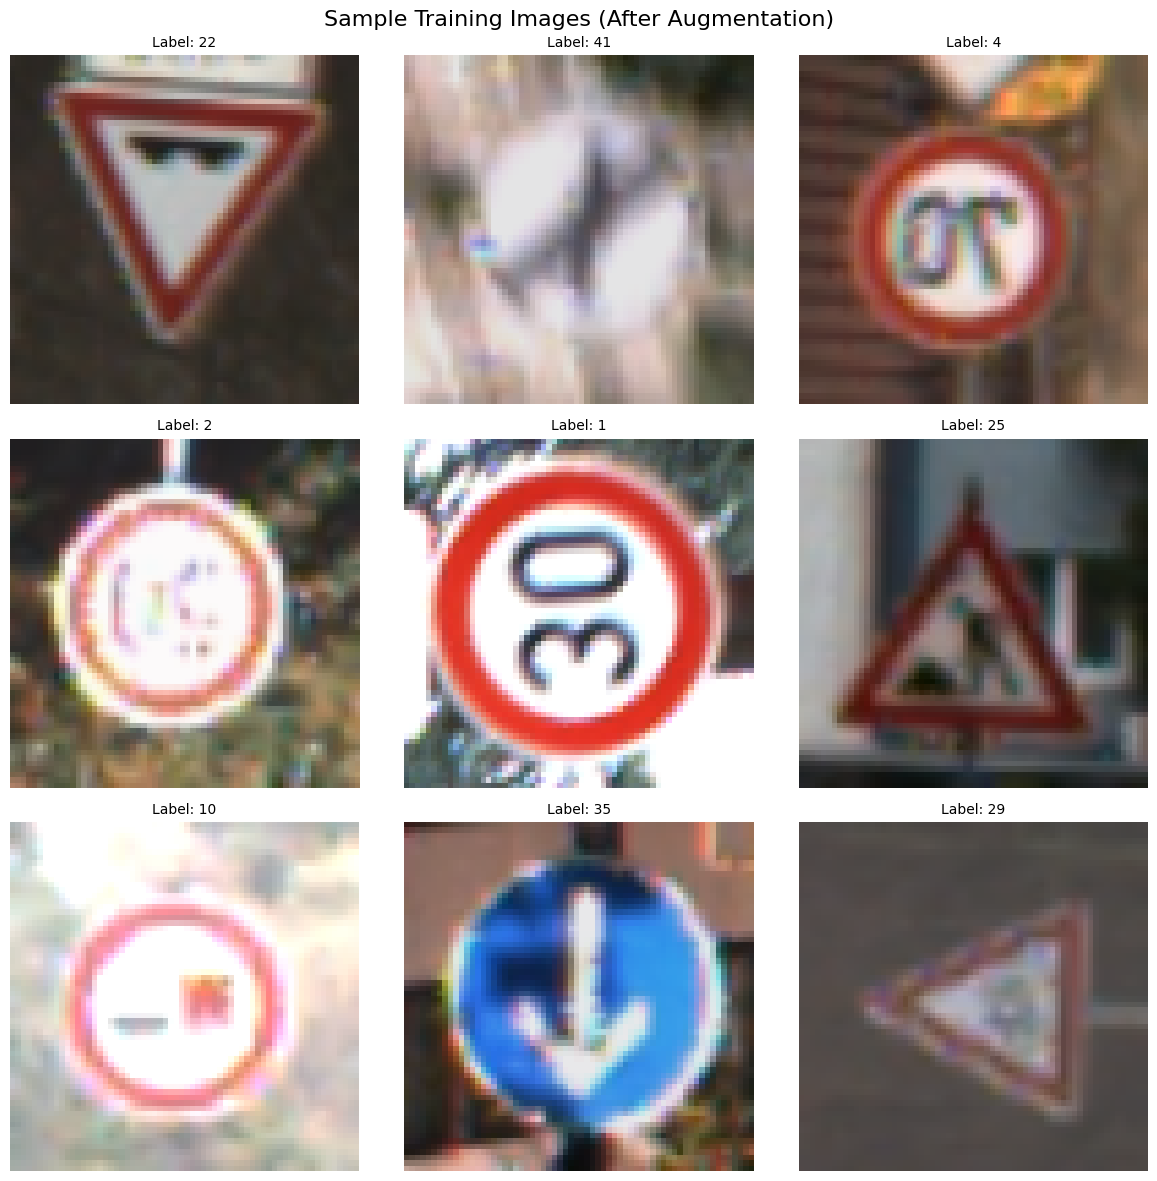

In [50]:
# Visualize Sample Training Images
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[i].numpy()}", fontsize=10)
    plt.axis("off")
plt.suptitle("Sample Training Images (After Augmentation)", fontsize=16)
plt.tight_layout()
plt.show()

# Model Development

## CNN Model

In [51]:
# Define model
cnn_model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(5e-5),  # ↓ was 1e-4
                  input_shape=(64,64,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(5e-5)),  # ↓
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(5e-5)),  # ↓
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(5e-5)),  # ↓
    layers.Dropout(0.25),  # ↓ was 0.3
    layers.Dense(43, activation='softmax')
])

In [52]:
# Compile
cnn_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [53]:
early_stop = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3,min_lr=1e-7)

In [54]:
steps_per_epoch = len(train_split) // 32 
validation_steps = len(val_split) // 32

In [55]:
# Train CNN
history_cnn = cnn_model.fit(train_ds,validation_data=val_ds,epochs=20, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr],verbose=1)

Epoch 1/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 557s 557ms/step - accuracy: 0.2473 - loss: 2.6769 - val_accuracy: 0.3893 - val_loss: 2.0583 - learning_rate: 0.0010
Epoch 2/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.8571 - loss: 1.1413 - val_accuracy: 0.3485 - val_loss: 2.1650 - learning_rate: 0.0010
Epoch 3/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 474s 482ms/step - accuracy: 0.5142 - loss: 1.5399 - val_accuracy: 0.6676 - val_loss: 1.0634 - learning_rate: 0.0010
Epoch 4/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - accuracy: 0.7143 - loss: 1.0371 - val_accuracy: 0.6668 - val_loss: 1.0806 - learning_rate: 0.0010
Epoch 5/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 572s 583ms/step - accuracy: 0.7095 - loss: 0.9184 - val_accuracy: 0.7767 - val_loss: 0.7108 - learning_rate: 0.0010
Epoch 6/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5714 - loss: 1.1575 - val_accuracy: 0.7477 - val_loss: 0.8007 - learning_rate: 0.0010
Epoch 7/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 537s 547ms/step - accuracy: 0.

In [56]:
# Evaluate CNN on train set
train_loss_cnn, train_accuracy_cnn = cnn_model.evaluate(train_ds, verbose=1)

print(f" CNN - Train Loss: {train_loss_cnn:.4f}")
print(f" CNN - Train Accuracy: {train_accuracy_cnn:.4f}")

981/981 ━━━━━━━━━━━━━━━━━━━━ 376s 363ms/step - accuracy: 0.9716 - loss: 0.1492
 CNN - Train Loss: 0.1492
 CNN - Train Accuracy: 0.9716


In [57]:
# Evaluate CNN on val set
val_loss_cnn, val_accuracy_cnn = cnn_model.evaluate(val_ds, verbose=1)

print(f" CNN - Val Loss: {val_loss_cnn:.4f}")
print(f" CNN - Val Accuracy: {val_accuracy_cnn:.4f}")

246/246 ━━━━━━━━━━━━━━━━━━━━ 93s 378ms/step - accuracy: 0.9674 - loss: 0.1624
 CNN - Val Loss: 0.1624
 CNN - Val Accuracy: 0.9674


In [58]:
# Evaluate the CNN model on the test set
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(test_ds, verbose=1)

print(f" CNN - Test Loss: {test_loss_cnn:.4f}")
print(f" CNN - Test Accuracy: {test_accuracy_cnn:.4f}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 203s 515ms/step - accuracy: 0.8827 - loss: 0.4666
 CNN - Test Loss: 0.4666
 CNN - Test Accuracy: 0.8827


In [59]:
# True labels from test set
y_test_true_cnn = np.concatenate([y for x, y in test_ds], axis=0)

# Predictions from CNN
y_test_pred_probs_cnn = cnn_model.predict(test_ds)
y_test_pred_cnn = np.argmax(y_test_pred_probs_cnn, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 52s 130ms/step


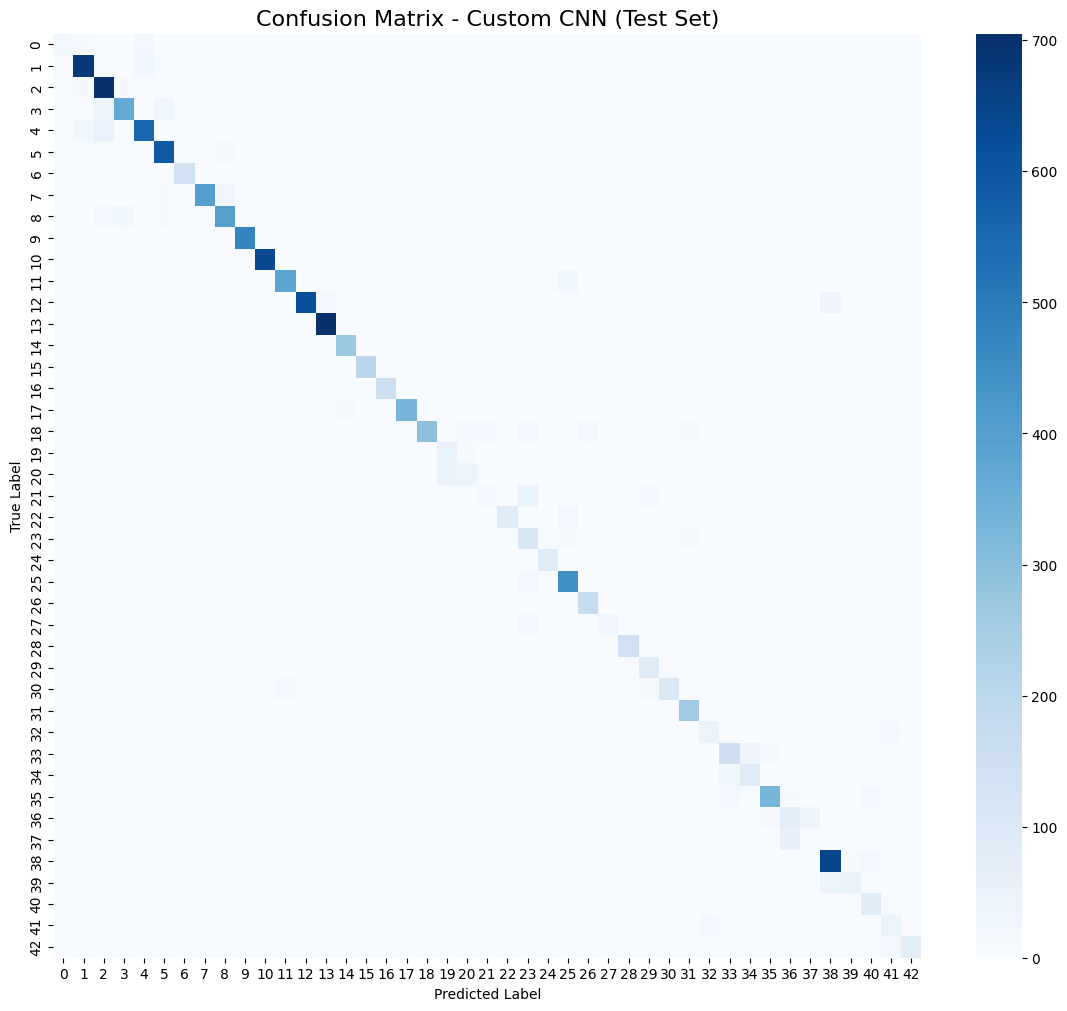

In [61]:
# Compute confusion matrix
cm_cnn = confusion_matrix(y_test_true_cnn, y_test_pred_cnn)

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(cm_cnn, cmap='Blues')
plt.title("Confusion Matrix - Custom CNN (Test Set)", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Flatten ảnh thành vector trước khi huấn luyện KNN
X_train_flat = X_train.numpy().reshape(len(X_train), -1)
X_test_flat = X_test.numpy().reshape(len(X_test), -1)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_flat, y_train.numpy())

y_pred_knn = knn.predict(X_test_flat)
print("KNN Accuracy:", accuracy_score(y_test.numpy(), y_pred_knn))


,precision,recall,f1-score,support
0,0.759,0.367,0.494,60.000
1,0.920,0.939,0.929,720.000
2,0.838,0.940,0.886,750.000
3,0.852,0.818,0.834,450.000
4,0.894,0.845,0.869,660.000
5,0.893,0.940,0.916,630.000
6,0.979,0.933,0.956,150.000
7,0.995,0.893,0.941,450.000
8,0.884,0.880,0.882,450.000
9,0.986,0.996,0.991,480.000
